In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from numba import jit
import scipy
from joblib import Parallel, delayed
import warnings

In [2]:
from scipy.stats import norm
def Black_Scholes_Call(S, K, r, vol, tau):
    """ 
    Black Scholes Model for European Call
    """
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)
    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    
    return V

For this equation, we conclude that
\begin{align}
    \vec{a_{-1}} &= \frac{1}{2}\sigma^{2}\frac{\Delta\tau}{\Delta X^{2}} - \frac{\Delta\tau}{2\Delta X}(r-\frac{1}{2}\sigma^{2}) \\
    \vec{a_{0}} &=  1- \sigma^{2}\frac{\Delta\tau}{\Delta X^{2}} - r\Delta\tau\\
    \vec{a_{+1}} &=  \frac{\Delta\tau}{2\Delta X}(r-\frac{1}{2}\sigma^{2})+\frac{1}{2}\sigma^{2}\frac{\Delta\tau}{\Delta X^{2}}
\end{align}

In [29]:
#@jit(fastmath=True,nopython=False)
def FD(S, K, r, sigma, T, N, M, scheme="FCTS"):
    # Compute delta T
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    
    if scheme=="FCTS":
        if not stability(S, K, r, sigma, T, N, M):
            warnings.warn('Stability cannot be ensured')
    
    
    s_max = X_true[-1]
    s_min = 0
    
    
    # Generate stock prices on log scale
    # Generate T * S grid
    V = np.zeros((M,N))

    # Put the discounted values into the first column
    V[:, 0] = [max(np.exp(s)-K,0) for s in X]
    V[0, -1] = s_max
    V[0, 0] = s_min
    # Fucking constants
    ss = sigma * sigma
    dxx = dx*dx
    
    # a-1, a0, a+1
    if scheme=="FCTS":
        f = (0.5*ss * dt / dxx)
        g = (r-0.5*ss) *dt / (2*dx)
        h = r * dt
        
        ad = f-g
        a0 = 1-2*f - h
        au = f+g
    else:       
        f = ((r-0.5*ss) * (dt/(4*dx)))
        g = (ss*dt)/(4*dxx)
        h = (r*dt/2)
        
        ad = g-f
        a0 = 1-2*g-h
        au = g+f
        
        
        bd = f-g
        b0 = 1+2*g+h
        bu = -f-g
        
        
    # Generate matrix A
    A = np.zeros((M,M))
    
    np.fill_diagonal(A[1:], ad)
    np.fill_diagonal(A[:,1:], au)
    np.fill_diagonal(A, a0)
    A[0,0], A[0,1], A[-1,-2], A[-1,-1] = 1,0, 0,1
    
    if scheme == "CN":
        B = np.zeros((M,M))
    
        np.fill_diagonal(B[1:], bd)
        np.fill_diagonal(B[:,1:], bu)
        np.fill_diagonal(B, b0)
        
        B[0,0], B[0,1], B[-1,-2], B[-1,-1] = 1,0, 0,1

        
    # main loop
    if scheme == "CN":
        for i in range(1,N):
            b = np.matmul(A, V[:, i-1])
            V[:, i]  = TDMA(B.diagonal(-1),B.diagonal(0), B.diagonal(+1), b)
    else:
        for i in range(1,N):
            V[:, i] = np.matmul(A, V[:, i-1])

    return A, V , X

# returns the answer from a result object
def get_ans(result, S):
    nearest_idx = np.where(abs(np.exp(result[2])-S)==abs(np.exp(result[2])-S).min())[0]
    return result[1][nearest_idx, -1]

def stability(S, K, r, sigma, T, N, M):
    # Compute delta T
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    mesh_ratio = (r-0.5*sigma**2)*(dt/dx) - 2*sigma**2 *(dt/dx**2) - r*dx
    if mesh_ratio >= -2:
        if mesh_ratio <= 0:
            return True
    return False



#https://stackoverflow.com/questions/8733015/tridiagonal-matrix-algorithm-tdma-aka-thomas-algorithm-using-python-with-nump
@jit(nopython=False)
def TDMA(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [30]:
sigma = 0.3
K = 110
S = 100
r = 0.04
T = 1
N = 1000 # time points
M =  1200# space points

In [23]:
%%time
Black_Scholes_Call(S, K, r, sigma, T)

Wall time: 0 ns


9.625357828843697

In [31]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="FCTS")
get_ans(result, S)

Wall time: 190 ms


<ipython-input-29-8c19d02d06bb>:18: UserWarning: Stability cannot be ensured
  warnings.warn('Stability cannot be ensured')


array([1.70457409e+307])

In [9]:
import logging;
logging.disable(logging.WARNING)

In [10]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="CN")
get_ans(result, S)

Wall time: 136 ms


array([9.61665255])

## Experiments

### Space experiment

In [32]:
def space_experiment(scheme, points):
    results = Parallel(n_jobs=10)(delayed(FD)(S, K, r, sigma, T, N, M=int(point), scheme=scheme)
                                 for point in points)
    final = []
    for result in results:
        final.append(get_ans(result, S))
        
    return final

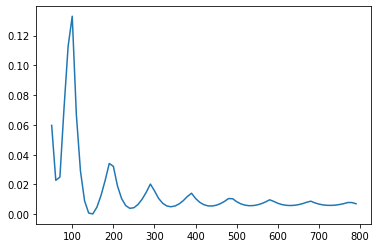

In [33]:
points = np.arange(50,800,10)
y = space_experiment("FCTS", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

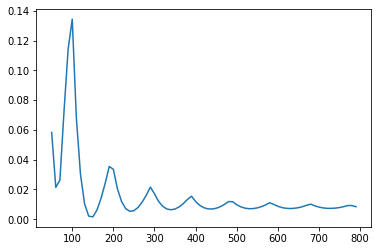

In [26]:
y = space_experiment("CN", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

In [34]:
points = np.arange(1000,7000,500)
y = space_experiment("CN", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

NameError: global name 'np' is not defined

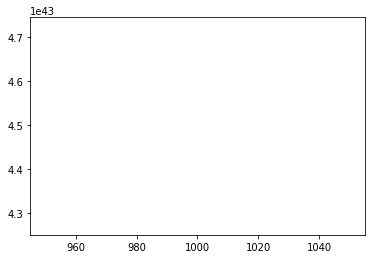

In [35]:
y = space_experiment("FCTS", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

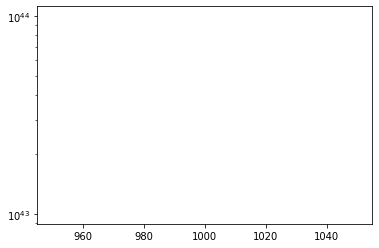

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))
ax.set_yscale("log")

### Experiment 2: Time points

In [36]:
def time_experiment(scheme, points):
    results = Parallel(n_jobs=10)(delayed(FD)(S, K, r, sigma, T, N=point, M=M, scheme=scheme)
                                 for point in points)
    final = []
    for result in results:
        final.append(get_ans(result, S))
        
    return final

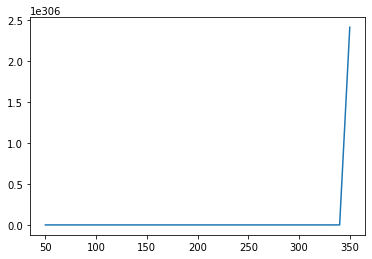

In [37]:
points = np.arange(50,800,10)
y = time_experiment("FCTS", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

In [38]:
result = FD(S, K, r, sigma, T, 350, M, scheme="FCTS")
get_ans(result, S)

<ipython-input-29-8c19d02d06bb>:18: UserWarning: Stability cannot be ensured
  warnings.warn('Stability cannot be ensured')


array([2.41734901e+306])

In [45]:
result = FD(S, K, r, sigma, T, 100, 300, scheme="FCTS")
get_ans(result, S)

array([9.55406867])

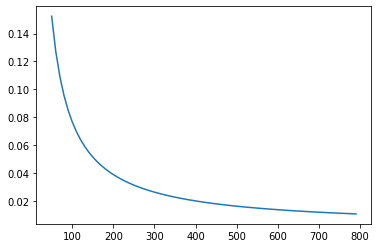

In [37]:
points = np.arange(50,800,10)
y = time_experiment("CN", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

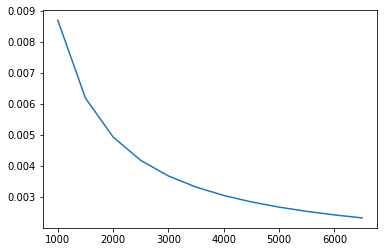

In [38]:
points = np.arange(1000,7000,500)
y = time_experiment("CN", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

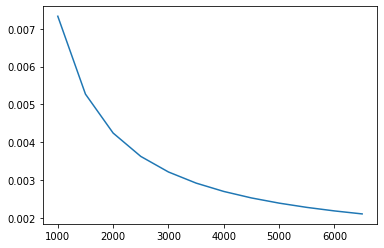

In [39]:
points = np.arange(1000,7000,500)
y = time_experiment("FCTS", points)
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))

### Conlusion: run CN with big mesh

In [51]:
result = FD(S, K, r, sigma, T, 10000, 10000, scheme="CN")
get_ans(result, S)
np.save("data/S_100", result[1])
np.save("data/X_S_100", result[2])

array([9.624605])

In [42]:
Black_Scholes_Call(S, K, r, sigma, T)

9.625357828843697

### Retrieve hedge parameter from data

In [54]:
def Delta_Analytical_Call(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

In [71]:
Delta_Analytical_Call(100, K, r, sigma, 1)

0.48629214299030143

In [64]:
def get_delta(result, S, timepoint = -1):
    nearest_idx = np.where(abs(np.exp(result[2])-S)==abs(np.exp(result[2])-S).min())[0]
    delV = result[1][nearest_idx+1, timepoint] - result[1][nearest_idx-1, timepoint]
    stonks = np.exp(result[2])
    delS = stonks[nearest_idx+1] - stonks[nearest_idx-1]
    return delV/delS

In [70]:
get_delta(result, 100)

array([0.48628043])

In [68]:
get_delta(result, 100, 30)

array([5.55997285e-09])

In [73]:
np.arange(80, 150, 3)

array([ 80,  83,  86,  89,  92,  95,  98, 101, 104, 107, 110, 113, 116,
       119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149])

In [90]:
deltas = []
ss = np.arange(20, 250, 3)
tt = [0,3000,-1]
for t in tt:
    time = []
    for s in ss:
        time.append(get_delta(result, s, t))
    deltas.append(time)

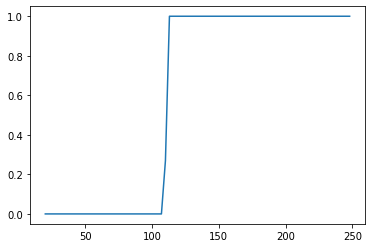

In [91]:
plt.plot(ss, deltas[0])

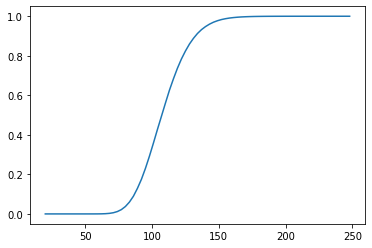

In [92]:
plt.plot(ss, deltas[1])

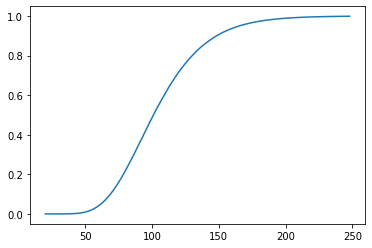

In [93]:
plt.plot(ss, deltas[2])